# ACL paper analysis

In [48]:
import os
import json
import random
import re
import pandas as pd
import numpy as np

## Load dataset of reviews

**chosen scores (1-5)**
- clarity
- recommendation
- substance
- reviewer confidence

**Reasons for chosen scores:**

`reviewer confidence` shows, how much the other scores can be trusted. Is used to weight them later.

`substance`, `clarity` have high pearson correlation coefficients with the final recommendation of the paper (page 4).

substance (1-5):  
Does this paper have enough substance, or would it benefit from more ideas or results? Note that this question mainly concerns the amount of work; its quality is evaluated in other categories.

clarity (1-5):  
For the reasonably well-prepared reader, is it clear what was done and why?
Is the paper well-written and well-structured?

details according to paper from: [https://github.com/allenai/PeerRead](https://github.com/allenai/PeerRead)

In [49]:
CONFERENCES = ["acl_2017"]
FILE_SPLIT_CATEGORIES = "dev,test,train".split(",")

# load accepted acl papers
accepted_paper_titles = []
with open(os.path.join("PeerRead", "data", "acl_accepted.txt"), "r") as fp:
    accepted_paper_titles = fp.read().split("\n")


# load all three arxiv paper categories
papers = {}
reviews = []
cols = "paper,clarity,substance,recommendation,reviewer_confidence".split(",")
for cat_id, category in enumerate(CONFERENCES):

    # load all three folders, i.e.: dev, train, test
    for split_id, file_split in enumerate(FILE_SPLIT_CATEGORIES):
        FOLDER_PATH = os.path.join("PeerRead", "data", category, file_split, "reviews")
        for f in os.listdir(FOLDER_PATH):
            filepath = os.path.join(FOLDER_PATH,f)
            if os.path.isfile(filepath) and f.endswith(".json"):
                
                with open(filepath, "r") as fp:
                    review_data = json.load(fp)
                    
                    # scores
                    for item in review_data['reviews']:
                        review = []
                        review.append(review_data['id'])
                        
                        review.append(item['CLARITY'])
                        review.append(item['SUBSTANCE'])
                        review.append(item['RECOMMENDATION'])
                        review.append(item['REVIEWER_CONFIDENCE'])
                        
                        reviews.append(review)
                        
                        
                    # accepted/ rejected based on acl_accepted.txt
                    # for acl not really existing according to paper -> rather aspect scores
                    papers[review_data['id']] = {}
                    papers[review_data['id']]['accepted'] = (review_data['title'] in accepted_paper_titles)
                    papers[review_data['id']]['cat'] = category
                    papers[review_data['id']]['split'] = file_split

In [50]:
df_papers = pd.DataFrame.from_dict(papers, orient='index')
df_papers = df_papers.reset_index().rename(columns={"index":"paper"})
df_papers.paper = pd.to_numeric(df_papers.paper)

df_reviews = pd.DataFrame(data=reviews, columns=cols)
df_reviews = df_reviews.apply(pd.to_numeric)

In [51]:
df_papers.head()

,paper,accepted,cat,split
0,660,True,acl_2017,dev
1,94,True,acl_2017,dev
2,37,True,acl_2017,dev
3,352,True,acl_2017,dev
4,489,True,acl_2017,dev


In [52]:
df_reviews

,paper,clarity,substance,recommendation,reviewer_confidence
0,660,4,5,4,3
1,660,3,4,3,4
2,94,5,4,4,5
3,37,4,4,4,2
4,352,4,4,4,2
...,...,...,...,...,...
270,706,4,4,4,4
271,706,5,4,4,3
272,614,4,4,4,4
273,614,4,4,2,4


## merge

group reviews by weighted average based upon the reviewer confidence score and merge

In [53]:
# lambda function for weighted average:
weighted_scoring = lambda x: np.average(x, weights=df_reviews.loc[x.index, "reviewer_confidence"])

df = (
    df_reviews
    .groupby(["paper"]).agg(
            review_count=("clarity","count"),
            clarity_weighted=('clarity', weighted_scoring),
            substance_weighted=('substance', weighted_scoring),
            recommendation_weighted=('recommendation', weighted_scoring))
    .reset_index()
    .sort_values(by="paper")
)
df = df.round(2)
df = pd.merge(df, df_papers, on="paper", how="right")

In [54]:
df.sort_values(by="paper").head(6)

,paper,review_count,clarity_weighted,substance_weighted,recommendation_weighted,accepted,cat,split
92,12,2,4.00,4.00,3.43,True,acl_2017,train
23,16,1,4.00,4.00,4.00,True,acl_2017,train
117,18,1,5.00,4.00,5.00,True,acl_2017,train
132,19,2,4.00,3.43,4.00,True,acl_2017,train
42,21,2,4.57,4.00,4.00,True,acl_2017,train
55,26,2,3.50,3.50,4.00,True,acl_2017,train


## Load full text

In [55]:
print(list(papers.keys())[:10])

print(papers['660'])

['660', '94', 37, '352', 489, '173', 371, 768, '355', '323']
{'accepted': True, 'cat': 'acl_2017', 'split': 'dev'}


In [56]:
full_text = []

for paper_id, metadata in papers.items():

    paper_file = os.path.join("PeerRead", "data", metadata['cat'], metadata['split'], "parsed_pdfs", f"{paper_id}.pdf.json")
    with open(paper_file, "r") as fp:
        abstracts = []
        sections = []
        content = json.load(fp)

        if content['metadata']['abstractText']:
            abstracts.append(content['metadata']['abstractText'])

        if content['metadata']['sections']:
            for section in content['metadata']['sections']:
                sections.append(section['text'])

        section_text = " ".join(sections)
        
        # clean up multiple whitespaces / new lines
        section_text = re.sub(r"\n", " ", section_text)
        section_text = re.sub(r" {2,}", " ", section_text)
        
        full_text.append([paper_id, "\n".join(abstracts), section_text])

df_full_text = pd.DataFrame(data=full_text, columns=["paper", "abstract", "text"])
df_full_text.paper = pd.to_numeric(df_full_text.paper)

In [57]:
df = pd.merge(df, df_full_text, on="paper", how="left")

In [58]:
df.head()

,paper,review_count,clarity_weighted,substance_weighted,recommendation_weighted,accepted,cat,split,abstract,text
0,660,2,3.43,4.43,3.43,True,acl_2017,dev,We propose two novel methodologies for the aut...,1 000 011 012 013 014 015 016 017 018 019 020 ...
1,94,1,5.00,4.00,4.00,True,acl_2017,dev,Restricted non-monotonicity has been shown ben...,1 000 011 012 013 014 015 016 017 018 019 020 ...
2,37,1,4.00,4.00,4.00,True,acl_2017,dev,We study response selection for multi-turn con...,1 000 011 012 013 014 015 016 017 018 019 020 ...
3,352,2,4.00,4.60,4.00,True,acl_2017,dev,Neural network models have shown their promisi...,1 000 011 012 013 014 015 016 017 018 019 020 ...
4,489,2,3.50,4.50,4.00,True,acl_2017,dev,We compare three recent models of referential ...,1 000 011 012 013 014 015 016 017 018 019 020 ...


## export

In [59]:
export_path = os.path.join("processed", "acl")
os.makedirs(export_path, exist_ok = True)
df.to_csv(os.path.join(export_path, "papers_with_scores_not_cleaned.csv"), index=False)

## analysis

In [60]:
import numpy as np
bin_array = np.linspace(start=0., stop=5., num=11)

<AxesSubplot:>

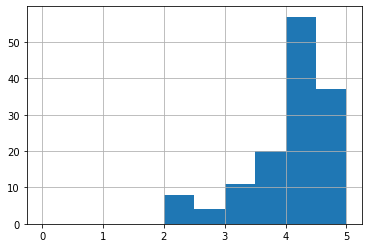

In [61]:
df.clarity_weighted.hist(bins=bin_array)

<AxesSubplot:>

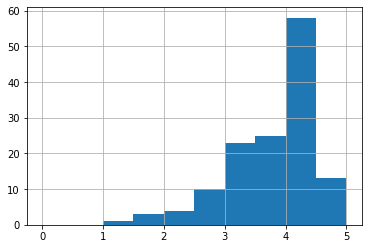

In [62]:
df.substance_weighted.hist(bins=bin_array)

<AxesSubplot:>

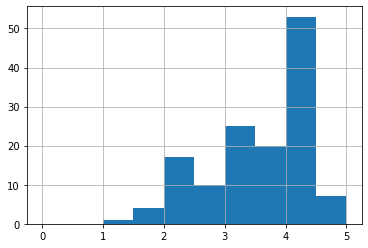

In [63]:
df.recommendation_weighted.hist(bins=bin_array)

## Cleaning text

In [64]:
import pandas as pd
import re
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize
import os, sys

In [65]:
def pattern_search(sentence_list, whitespace_separated = False):

    clean_sentence_list = []

    p_basic = r"(@x)|(\[\s)|(\{)" # contains @x or [ or {
    p_char = r"[^a-zA-Z\s.\-,()!?\"':;]" # contains anything else than a-z, A-Z, whitespace, - ,()!?"'+:;=
    p_cit = r"\s\w[.]\s" # contains whitespace+letter+period+whitespace
    p_etal = r"et al" # contains et al
    p_link = r"(http)|(www)|([.]com)" # contains http or www or .com
    p_punct = r"[a-zA-Z][.!?\-]"
    p_ieeg = r"\si\.e\.|\se\.g\.|\sfig\s"

    for i, sentence in enumerate(sentence_list):
        var = False
        # can't contain @x or [ or {
        if not re.search(p_basic, sentence):
            # can't contain anything else than a-z and few exceptions
            if not re.search(p_char, sentence):
                # can't contain j. citations and other single letter before period
                if not re.search(p_cit, sentence):
                    # can't contain et al
                    if not re.search(p_etal, sentence):
                        # can't contain link
                        if not re.search(p_link, sentence):
                            # Filter out letter followed by period
                            if whitespace_separated == False:
                                if not re.search(p_ieeg,sentence):
                                    var = True
                            else:
                                if not re.search(p_punct, sentence):
                                    var = True
        if var == True:
            clean_sentence_list.append(sentence)
    return clean_sentence_list

def sentence_filter(sentence_list):
    clean_sentence_list = []
    for i, sent in enumerate(sentence_list):
        # Multiple whitespaces to one
        sent = re.sub(r"\s+",r" ",sent)
        # Clean second part of sentece if letter+whitespace+period is followed by any text
        sent = re.sub(r"(\w\s[.]).+",r"\1",sent)
        # Clean whitespaces before punctuations
        sent = re.sub(r"\s([.,!?:;])",r"\1",sent)
        # Clean start of sentence
        sent = re.sub(r"^[^\w]+",r"",sent)
        # Clean whitespaces before and after hyphen and parentheses
        sent = re.sub(r"([(\-])\s(\w)",r"\1\2",sent)
        sent = re.sub(r"(\w)\s([)\-])",r"\1\2",sent)
        clean_sentence_list.append(sent)
    return clean_sentence_list

In [66]:
csv_path = os.path.join("processed", "acl", "papers_with_scores_not_cleaned.csv")

papers_with_scores = pd.read_csv(csv_path)

print(len(papers_with_scores['text']))

137


In [67]:
example_article = sent_tokenize(papers_with_scores['text'][0])
print(len(example_article))

example_article = pattern_search(example_article)
print(len(example_article))

example_article = sentence_filter(example_article)
print(len(example_article))

220
138
138


In [68]:
clean_sentence_lists = []

for i, article in enumerate(papers_with_scores['text']):
    sentence_list = sent_tokenize(article)
    sentence_list = pattern_search(sentence_list)
    sentence_list = sentence_filter(sentence_list)
    
    sentences = " ".join(sentence_list)
    clean_sentence_lists.append(sentences)

papers_with_scores['text_clean'] = clean_sentence_lists

In [69]:
papers_with_scores.head(2)

,paper,review_count,clarity_weighted,substance_weighted,recommendation_weighted,accepted,cat,split,abstract,text,text_clean
0,660,2,3.43,4.43,3.43,True,acl_2017,dev,We propose two novel methodologies for the aut...,1 000 011 012 013 014 015 016 017 018 019 020 ...,The first approach uses a neural language mode...
1,94,1,5.00,4.00,4.00,True,acl_2017,dev,Restricted non-monotonicity has been shown ben...,1 000 011 012 013 014 015 016 017 018 019 020 ...,They parse a sentence from left to right by gr...


In [73]:
# export
papers_with_scores.drop("text", axis=1).to_csv(os.path.join(export_path, "papers_with_scores_cleaned.csv"), index=False)